## Homework

The goal of this homework is to create a classification model to determine whether the customer will subscribe to a term deposit or not (column `'y'`).

### Setup

In [47]:
import sys
import zipfile
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import sklearn as skl
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split

print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Scikit-learn version: {skl.__version__}")
print("Setup Complete")

Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
NumPy version: 1.26.4
Pandas version: 2.2.2
Seaborn version: 0.13.2
Scikit-learn version: 1.4.2
Setup Complete



### Dataset

In this homework, we will use the Bank Marketing dataset. Download it from: https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

We need to take `bank/bank-full.csv` file from the downloaded zip-file.  
In this dataset our desired target for classification task will be `y` variable - has the client subscribed a term deposit or not. 

In [2]:
def get_bank_marketing_data(url, inner_zip_name, csv_name): 
    """
    Downloads a nested zip file from a URL and reads a CSV file from it into a pandas DataFrame.

    Parameters:
    url (str): The URL of the outer zip file.
    inner_zip_name (str): The name of the inner zip file inside the outer zip file.
    csv_name (str): The name of the CSV file inside the inner zip file.

    Returns:
    pd.DataFrame: DataFrame containing the data from the CSV file.
    """
    # Download the outer zip file
    response = requests.get(url)
    outer_zip_bytes = BytesIO(response.content)

    # Open the outer zip file
    with zipfile.ZipFile(outer_zip_bytes, 'r') as outer_zip:
        # Read the inner zip file as a file in memory
        with outer_zip.open(inner_zip_name) as inner_zip_file:
            with zipfile.ZipFile(BytesIO(inner_zip_file.read()), 'r') as inner_zip:
                # Read the CSV file directly into a pandas DataFrame
                with inner_zip.open(csv_name) as csv_file:
                    df = pd.read_csv(csv_file, sep=';')
    
    return df


In [3]:
# URL of the external .zip file
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
inner_zip_name = 'bank.zip'
csv_name = 'bank-full.csv'


In [4]:
# Get the data and display the first few rows
df = get_bank_marketing_data(url, inner_zip_name, csv_name)
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Features

For the rest of the homework, you'll need to use only these columns:


In [6]:
features = [
    "age",
    "job",
    "marital",
    "education",
    "balance",
    "housing",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
    "y",
]

### Data preparation

* Select only the features from above.

In [7]:
df = df[features]
df.columns


Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'y'],
      dtype='object')

* Check if the missing values are presented in the features.

In [8]:
df.isna().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### Question 1

What is the most frequent observation (mode) for the column `education`?

- `unknown`
- `primary`
- `secondary`
- `tertiary`


In [9]:
education_mode = df.education.mode()[0]
print(f"The most frequent observation (mode) for the column 'education' is: {education_mode}")


The most frequent observation (mode) for the column 'education' is: secondary


### Question 2

Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your dataset. 
In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?

- `age` and `balance`
- `day` and `campaign`
- `day` and `pdays`
- `pdays` and `previous`


In [10]:
corr = df.corr(numeric_only=True)
corr


,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


<Axes: >

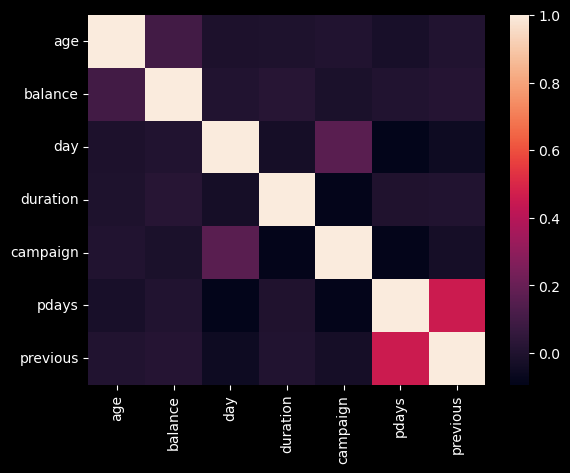

In [11]:
sns.heatmap(corr)

### Target encoding

* Now we want to encode the `y` variable.
* Let's replace the values `yes`/`no` with `1`/`0`.

In [12]:
df.y = (df.y == 'yes').astype(int)
df.y.value_counts()


y
0    39922
1     5289
Name: count, dtype: int64

### Split the data

* Split your data in train/val/test sets with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the `train_test_split` function) and set the seed to `42`.
* Make sure that the target value `y` is not in your dataframe.


In [13]:
def split_data(df, target_column, test_size=0.2, val_size=0.2, random_state=42):
    """
    Splits the data into train, validation, and test sets with specified distribution.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    target_column (str): The name of the target column.
    test_size (float): The proportion of the dataset to include in the test split.
    val_size (float): The proportion of the dataset to include in the validation split.
    random_state (int): The seed used by the random number generator.

    Returns:
    tuple: Four DataFrames (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # First split: train and temporary (temp) data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(test_size + val_size), random_state=random_state
    )

    # Second split: validation and test data from temp data
    X_val, X_test = train_test_split(
        X_temp, test_size=test_size / (test_size + val_size), random_state=random_state
    )
    y_val, y_test = train_test_split(
        y_temp, test_size=test_size / (test_size + val_size), random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [14]:

target_column = 'y'  
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, target_column)

# Display the sizes of the splits
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 27126
Validation set size: 9042
Test set size: 9043


In [15]:
def split_data(df, test_size=0.2, val_size=0.25, random_state=42):

    """
    Split the data into train, validation, and test sets.
    
    Args:
    df (pd.DataFrame): The input dataframe
    test_size (float): Proportion of data to be used for testing
    val_size (float): Proportion of training data to be used for validation
    random_state (int): Seed for random number generator
    
    Returns:
    tuple: (df_train, df_val, df_test, y_train, y_val, y_test)
    """
    # Split into train+val and test
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Split train+val into train and val
    df_train, df_val = train_test_split(df_full_train, test_size=val_size, random_state=random_state)
    
    # Reset indices
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    # Extract target variable
    y_train = df_train.pop('y').values
    y_val = df_val.pop('y').values
    y_test = df_test.pop('y').values
    
    return df_train, df_val, df_test, y_train, y_val, y_test

In [16]:
# Usage
df_train, df_val, df_test, y_train, y_val, y_test = split_data(df)

# Print sizes of resulting datasets
print(f"Train set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Train set size: 27126
Validation set size: 9042
Test set size: 9043


In [19]:
df_train

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
0,32,technician,single,tertiary,1100,yes,cellular,11,aug,67,1,-1,0,unknown
1,38,entrepreneur,married,secondary,0,yes,cellular,17,nov,258,1,-1,0,unknown
2,49,blue-collar,married,secondary,3309,yes,cellular,15,may,349,2,-1,0,unknown
3,37,housemaid,married,primary,2410,no,cellular,4,aug,315,1,-1,0,unknown
4,31,self-employed,married,tertiary,3220,no,cellular,26,aug,74,4,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27121,27,services,single,secondary,167,no,cellular,8,jul,606,2,-1,0,unknown
27122,40,technician,single,tertiary,693,no,cellular,30,jan,427,1,-1,0,unknown
27123,54,technician,divorced,secondary,0,yes,unknown,16,may,161,1,-1,0,unknown
27124,25,services,single,secondary,2311,no,cellular,21,jul,1105,2,-1,0,unknown


In [18]:
# Print sizes of resulting datasets
print(f"Train set size: {len(y_train)}")
print(f"Validation set size: {len(y_val)}")
print(f"Test set size: {len(y_test)}")

Train set size: 27126
Validation set size: 9042
Test set size: 9043


### Question 3

* Calculate the mutual information score between `y` and other categorical variables in the dataset. Use the training set only.
* Round the scores to 2 decimals using `round(score, 2)`.

Which of these variables has the biggest mutual information score?
  
- `contact`
- `education`
- `housing`
- `poutcome`


In [45]:
def mutual_info_y_score(series):
    return round(mutual_info_score(series, y_train), 2)

In [ ]:

def calculate_mutual_information(X_train, y_train):
    """
    Calculates the mutual information score between y and other categorical variables in the dataset.
    
    Parameters:
    X_train (pd.DataFrame): The training set features.
    y_train (pd.Series): The training set target variable.
    
    Returns:
    dict: A dictionary with variable names as keys and mutual information scores as values, rounded to 2 decimals.
    """
    # Select only categorical variables
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
    
    # Calculate mutual information scores
    mi_scores = mutual_info_score(X_train[categorical_features], y_train)
    mi = df_train[categorical_features].apply(mutual_info_y_score)
    
    # Create a dictionary with variable names and their mutual information scores
    mi_dict = {feature: round(score, 2) for feature, score in zip(categorical_features, mi_scores)}
    
    return mi_dict

# Example usage
# Assuming X_train and y_train are already defined
mi_scores = calculate_mutual_information(df_train, y_train)

# Display the mutual information scores
print(mi_scores)


In [27]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

In [46]:
mi = df_train[categorical_features].apply(mutual_info_y_score)
mi.sort_values(ascending=False)

month        0.03
poutcome     0.03
job          0.01
housing      0.01
contact      0.01
marital      0.00
education    0.00
dtype: float64

### Question 4

* Now let's train a logistic regression.
* Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

- 0.6
- 0.7
- 0.8
- 0.9


In [48]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [42]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [49]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [50]:
y_pred = model.predict_proba(X_val)[:, 1]

In [51]:
churn_decision = (y_pred >= 0.5)

In [53]:
round((y_val == churn_decision).mean(), 2)

0.9

In [54]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val

In [55]:
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [57]:
df_pred

,probability,prediction,actual,correct
0,0.012572,0,0,True
1,0.009616,0,0,True
2,0.147161,0,1,False
3,0.222515,0,0,True
4,0.434919,0,1,False
...,...,...,...,...
9037,0.023187,0,0,True
9038,0.274199,0,1,False
9039,0.056363,0,0,True
9040,0.008858,0,0,True


In [56]:
round(df_pred.correct.mean(), 2)

0.9

### Question 5 

* Let's find the least useful feature using the *feature elimination* technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature. 

Which of following feature has the smallest difference?

- `age`
- `balance`
- `marital`
- `previous`

> **Note**: The difference doesn't have to be positive.

### Question 6

* Now let's train a regularized logistic regression.
* Let's try the following values of the parameter `C`: `[0.01, 0.1, 1, 10, 100]`.
* Train models using all the features as in Q4.
* Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

Which of these `C` leads to the best accuracy on the validation set?

- 0.01
- 0.1
- 1
- 10
- 100

> **Note**: If there are multiple options, select the smallest `C`.


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw03
* If your answer doesn't match options exactly, select the closest one
